<a href="https://colab.research.google.com/github/sundarjhu/Astrostatistics2025/blob/main/Lesson19_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install pyvo torch scikit-learn matplotlib pandas numpy

# Neural Networks for Predicting Stellar Parameters

This notebook demonstrates how neural networks can model relationships in astronomical data.

**Goals:**
1. Retrieve real photometric and astrophysical data from Gaia DR3 joined with 2MASS.
2. Compare a linear regression baseline with neural network regressors.
3. Demonstrate overfitting and regularization effects.
4. Discuss network depth and complexity trade-offs.

## Step 1: Retrieve Gaia + 2MASS Data via PyVO

We will query the VizieR TAP service (`https://tapvizier.cds.unistra.fr/TAPVizieR/tap`) to join the Gaia DR3 main photometry table (`I/355/gaiadr3`) with the 2MASS photometric catalog (`II/246/out`).

In [31]:
import pyvo, pandas as pd
service = pyvo.dal.TAPService('https://tapvizier.cds.unistra.fr/TAPVizieR/tap')
query = '''
SELECT TOP 100
    g."Source", g."2MASS", g."Gmag", g."Teff",
    t."Jmag", t."Hmag", t."Kmag"
FROM "I/355/gaiadr3" AS g
JOIN "II/246/out" AS t
    ON g."2MASS" = t."2MASS"
WHERE g."Teff" BETWEEN 3000 AND 8000
  AND g."2MASS" IS NOT NULL AND g."Gmag" IS NOT NULL
  AND t."Jmag" IS NOT NULL AND t."Hmag" IS NOT NULL AND t."Kmag" IS NOT NULL
'''
result = service.search(query)
df = result.to_table().to_pandas()
print(f'Retrieved {len(df)} stars after join and filtering.')
df.head()

Retrieved 100 stars after join and filtering.


,Source,2MASS,Gmag,Teff,Jmag,Hmag,Kmag
0,2340049335646007168,00000000-2304300,15.522836,5574.200195,14.478,14.108,14.084
1,2882189828921792896,00000000+4041242,14.966888,5778.399902,13.844,13.503,13.430
2,387274319159125888,00000000+4743524,18.225746,3493.800049,15.554,14.864,14.552
3,1939556073526558976,00000000+4819419,15.518135,4706.600098,13.887,13.397,13.243
4,393877986003880960,00000000+4946482,17.797430,3473.600098,15.128,14.398,14.074


## Step 2: Feature Engineering

We will use color indices $(G-J)$, $(J-H)$, and $(H-K)$ as features and predict $\log_{10}(T_{\mathrm{eff}})$.

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.vstack([
    df['Gmag'] - df['Jmag'],
    df['Jmag'] - df['Hmag'],
    df['Hmag'] - df['Kmag']
]).T
y = np.log10(df['Teff'].values)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Step 3: Linear Regression Baseline

We begin with a frequentist linear regression model and visualize predicted versus true values.

Linear regression MSE: 0.0018


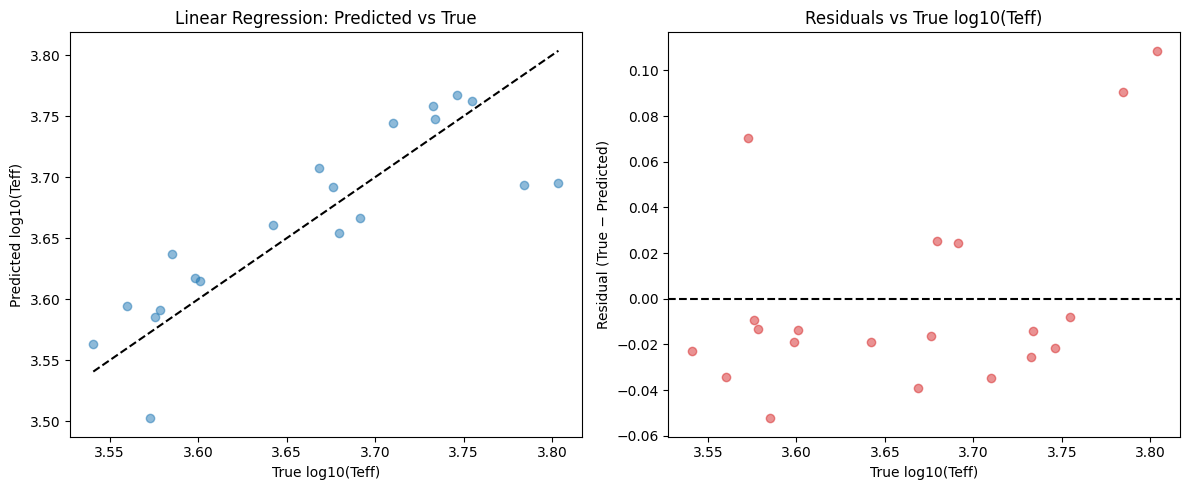

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

linreg = LinearRegression().fit(X_train, y_train)
pred_val_lin = linreg.predict(X_val)
mse_lin = mean_squared_error(y_val, pred_val_lin)
print(f'Linear regression MSE: {mse_lin:.4f}')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_val, pred_val_lin, alpha=0.5)
lims = [np.min(y_val), np.max(y_val)]
plt.plot(lims, lims, 'k--')
plt.xlabel('True log10(Teff)')
plt.ylabel('Predicted log10(Teff)')
plt.title('Linear Regression: Predicted vs True')

plt.subplot(1,2,2)
residuals = y_val - pred_val_lin
plt.scatter(y_val, residuals, alpha=0.5, color='tab:red')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('True log10(Teff)')
plt.ylabel('Residual (True − Predicted)')
plt.title('Residuals vs True log10(Teff)')
plt.tight_layout()
plt.show()

## Step 4: Neural Network Introduction

A **multilayer perceptron (MLP)** consists of an input layer, one or more hidden layers, and an output layer. Each neuron computes a weighted sum followed by a nonlinear activation function, such as ReLU.

The diagram below shows a schematic for a two-hidden-layer MLP.

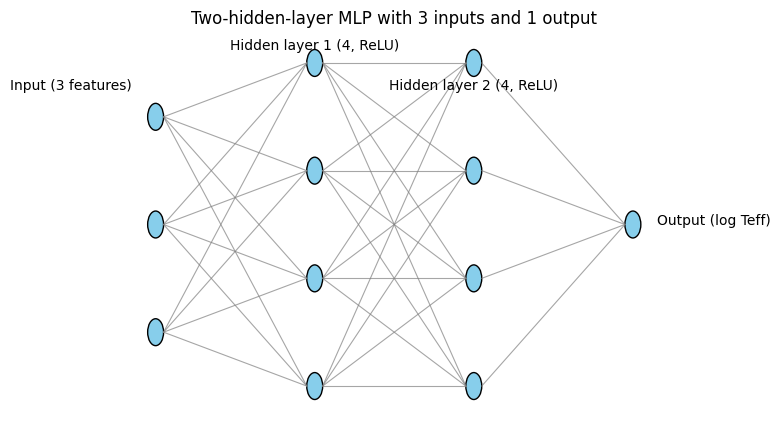

In [34]:
fig, ax = plt.subplots(figsize=(7,5))
ax.axis('off')
layers = {'Input': [(0,0.8),(0,0),(0,-0.8)], 'Hidden1': [(2,1.2),(2,0.4),(2,-0.4),(2,-1.2)], 'Hidden2': [(4,1.2),(4,0.4),(4,-0.4),(4,-1.2)], 'Output': [(6,0)]}
for coords in layers.values():
    for (x,y) in coords:
        ax.add_patch(plt.Circle((x,y),0.1,color='skyblue',ec='k'))
def connect(a,b):
    for (x1,y1) in a:
        for (x2,y2) in b:
            ax.plot([x1+0.1,x2-0.1],[y1,y2],'gray',lw=0.8,alpha=0.7)
connect(layers['Input'], layers['Hidden1'])
connect(layers['Hidden1'], layers['Hidden2'])
connect(layers['Hidden2'], layers['Output'])
ax.text(-0.3,1,'Input (3 features)',ha='right')
ax.text(2,1.3,'Hidden layer 1 (4, ReLU)',ha='center')
ax.text(4,1,'Hidden layer 2 (4, ReLU)',ha='center')
ax.text(6.3,0,'Output (log Teff)',ha='left')
plt.title('Two-hidden-layer MLP with 3 inputs and 1 output')
plt.show()

## Step 5: Neural Network Training
We train an MLP with two hidden layers and 32 neurons per layer using ReLU activation and the Adam optimizer. Training and validation losses are printed every 25 epochs.

### Learning Rate (`lr`)

The **learning rate** controls the *step size* that the optimizer takes when adjusting the network’s weights during training.  

- A **large** learning rate (e.g., `1e-2`) makes big jumps toward minima, speeding up training but risking overshooting or divergence.  
- A **small** learning rate (e.g., `1e-4` or `1e-5`) yields slow but stable convergence, often required when training deep or noisy models.  

Mathematically, for a weight $w$, the update rule under gradient descent is:  
$w_{t+1} = w_t - \eta \, \nabla L(w_t)$  
where $\eta$ is the learning rate and $\nabla L(w_t)$ is the gradient of the loss with respect to the weights.  

Choosing the right `lr` is crucial — too high causes instability, too low causes painfully slow learning.  
In this notebook, we use `lr = 1e-3`, a common default for the **Adam** optimizer, which adapts learning rates individually for each parameter.


In [39]:
import torch, torch.nn as nn, torch.optim as optim

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3,32), nn.ReLU(),
            nn.Linear(32,32), nn.ReLU(),
            nn.Linear(32,1)
        )
    def forward(self,x): return self.net(x)

model = Net()
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

train_L, val_L = [], []
epochs = 500
for e in range(epochs):
    model.train(); opt.zero_grad()
    pred = model(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward(); opt.step()
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_val_t), y_val_t).item()
    train_L.append(loss.item()); val_L.append(val_loss)
    if (e+1)%25==0:
        print(f'Epoch {e+1}: train={loss.item():.4f}, val={val_loss:.4f}')

Epoch 25: train=8.8110, val=8.7670
Epoch 50: train=4.2176, val=4.1656
Epoch 75: train=1.0346, val=1.1144
Epoch 100: train=0.8171, val=0.9383
Epoch 125: train=0.7315, val=0.8473
Epoch 150: train=0.6685, val=0.7827
Epoch 175: train=0.6066, val=0.7180
Epoch 200: train=0.5447, val=0.6538
Epoch 225: train=0.4833, val=0.5904
Epoch 250: train=0.4232, val=0.5285
Epoch 275: train=0.3649, val=0.4686
Epoch 300: train=0.3093, val=0.4113
Epoch 325: train=0.2573, val=0.3573
Epoch 350: train=0.2102, val=0.3078
Epoch 375: train=0.1688, val=0.2621
Epoch 400: train=0.1337, val=0.2223
Epoch 425: train=0.1051, val=0.1876
Epoch 450: train=0.0829, val=0.1586
Epoch 475: train=0.0662, val=0.1343
Epoch 500: train=0.0539, val=0.1135


## Step 6: Architecture Depth Comparison
We now compare three architectures: 2×32, 3×64, and 5×64 layers to study capacity vs overfitting.

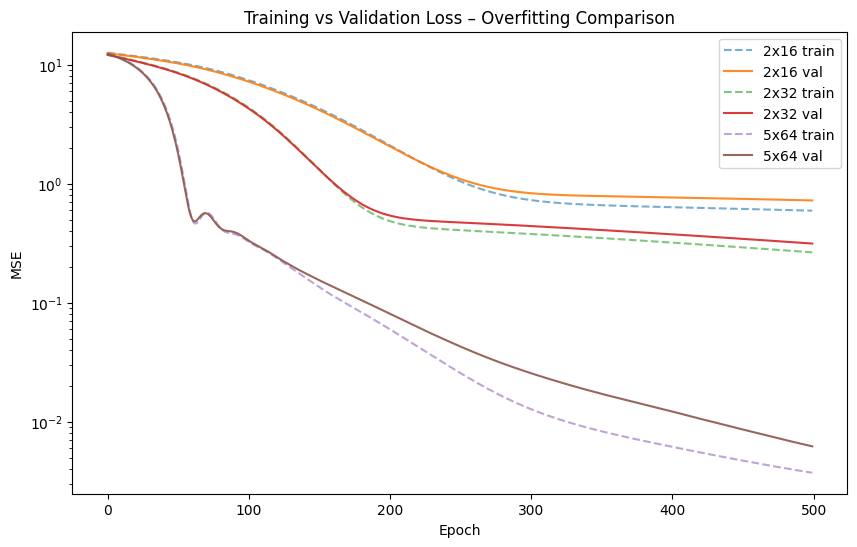

In [47]:
architectures = [(2,16,'2x16'), (2,32,'2x32'), (4,32,'5x64')]
results = {}
epochs = 500
for nL, nN, label in architectures:
    layers = [nn.Linear(3,nN), nn.ReLU()]
    for _ in range(nL-2):
        layers += [nn.Linear(nN,nN), nn.ReLU()]
    layers += [nn.Linear(nN,1)]
    model = nn.Sequential(*layers)
    opt = optim.Adam(model.parameters(), lr=1e-3)
    tL, vL = [], []
    for e in range(epochs):
        model.train(); opt.zero_grad()
        pred = model(X_train_t); loss = criterion(pred, y_train_t)
        loss.backward(); opt.step()
        model.eval()
        with torch.no_grad(): val = criterion(model(X_val_t), y_val_t).item()
        tL.append(loss.item()); vL.append(val)
    results[label] = (tL,vL)

# Plot both training and validation curves to expose overfitting
plt.figure(figsize=(10,6))
for label,(tL,vL) in results.items():
    plt.plot(tL, '--', alpha=0.6, label=f'{label} train')
    plt.plot(vL, alpha=0.9, label=f'{label} val')
plt.title('Training vs Validation Loss – Overfitting Comparison')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.show()


### Step 7
### Regularization: Controlling Model Complexity

The overfitting we just observed occurs when the network has **too many parameters relative to the information content** of the data.  
To prevent the model from simply memorizing the training set, we introduce **regularization** — a set of techniques that constrain or penalize excessive flexibility in the model.

---

#### 🔹 Weight Decay (L2 Regularization)

Weight decay adds a penalty proportional to the **sum of squared weights** to the loss function:
\[
L_{\text{total}} = L_{\text{data}} + \lambda \sum_i w_i^2
\]
This discourages large weight values, effectively smoothing the learned function and reducing sensitivity to noise.  
In PyTorch, this is implemented through the `weight_decay` parameter in optimizers such as `Adam`.

- Large \( \lambda \) → stronger penalty, smoother model.  
- Small \( \lambda \) → weaker penalty, closer to an unregularized fit.

---

#### 🔹 Dropout

Dropout randomly “turns off” a fraction of neurons during each training step (for example, 20% of them), forcing the network to rely on multiple independent representations of the data rather than specific weight configurations.  
Mathematically, dropout introduces noise into the network’s architecture:
$
\tilde{h}_i = h_i \cdot z_i, \quad z_i \sim \text{Bernoulli}(p)
$
where $p$ is the probability of *keeping* a neuron active.

- Dropout prevents **co-adaptation** of neurons.
- At inference time, all neurons are active but their outputs are scaled by $p$.

---

#### 🔹 Combined Effect

Using **both dropout and weight decay** produces a more stable and generalizable model:

- Training loss decreases more slowly (the model learns more cautiously).  
- Validation loss stabilizes instead of diverging — the hallmark of improved generalization.  
- The gap between train and validation curves narrows.

In the next code cell, we’ll retrain the overfitted 5×64 network using dropout and weight decay to demonstrate how these regularization methods suppress overfitting.


Epoch 50: train=0.9475, val=0.5738
Epoch 100: train=0.3457, val=0.0327
Epoch 150: train=0.3147, val=0.0191
Epoch 200: train=0.3164, val=0.0106
Epoch 250: train=0.2199, val=0.0436
Epoch 300: train=0.2598, val=0.0203
Epoch 350: train=0.1768, val=0.0408
Epoch 400: train=0.1897, val=0.0604
Epoch 450: train=0.1892, val=0.0294
Epoch 500: train=0.1761, val=0.0820


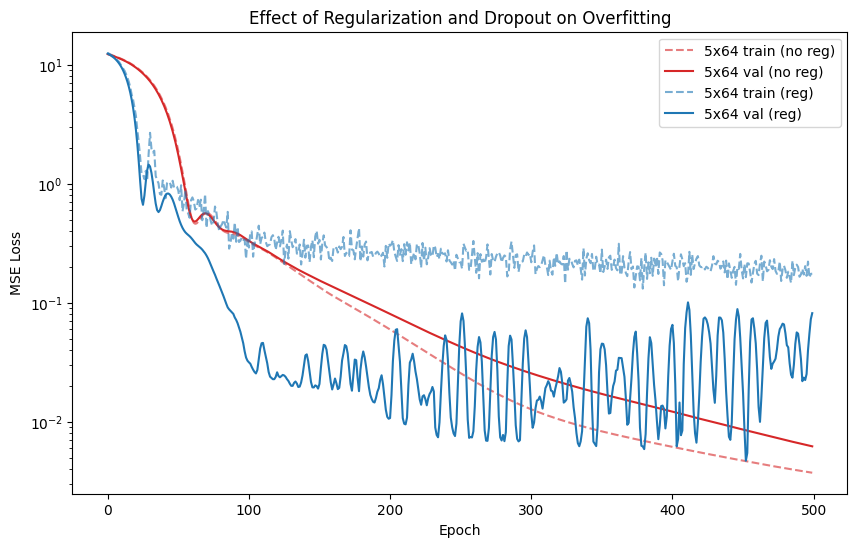

In [48]:
# --- Demonstration: Regularization and Dropout ---

class NetReg(nn.Module):
    def __init__(self, n_in=3, n_hidden=64, n_layers=5, dropout=0.2):
        super().__init__()
        layers = []
        layers.append(nn.Linear(n_in, n_hidden))
        layers.append(nn.ReLU())
        for _ in range(n_layers - 2):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(n_hidden, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model_reg = NetReg()
criterion = nn.MSELoss()
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 500
train_reg, val_reg = [], []

for e in range(epochs):
    model_reg.train()
    optimizer_reg.zero_grad()
    pred = model_reg(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward()
    optimizer_reg.step()

    model_reg.eval()
    with torch.no_grad():
        val = criterion(model_reg(X_val_t), y_val_t).item()
    train_reg.append(loss.item())
    val_reg.append(val)
    if (e+1) % 50 == 0:
        print(f"Epoch {e+1}: train={loss.item():.4f}, val={val:.4f}")

# --- Plot comparison with previous overfitted model (5x64) ---
plt.figure(figsize=(10,6))
plt.plot(results['5x64'][0], '--', color='tab:red', alpha=0.6, label='5x64 train (no reg)')
plt.plot(results['5x64'][1], color='tab:red', label='5x64 val (no reg)')
plt.plot(train_reg, '--', color='tab:blue', alpha=0.6, label='5x64 train (reg)')
plt.plot(val_reg, color='tab:blue', label='5x64 val (reg)')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Effect of Regularization and Dropout on Overfitting')
plt.legend()
plt.show()


> **Note on Oscillations in the Regularized Curves**  
> The high-frequency oscillations visible in the regularized training and validation losses are a direct consequence of **dropout-induced noise** combined with the **small dataset size**.  
>
> - Dropout randomly deactivates neurons at each iteration, so each update is based on a slightly different subnetwork. This increases gradient noise and produces visible fluctuations in the loss.  
> - With a small dataset, each batch has high variance, amplifying the effect.  
> - A relatively high learning rate (`1e-3`) further contributes to oscillations by causing the optimizer to overshoot minima.  
>
> These oscillations are not an error — they reflect the **stochastic nature of dropout**. The key point is that despite the noise, the **validation loss trend** is flatter (on average, hehe) and lower than in the unregularized case, confirming that **dropout and weight decay improve generalization** even if convergence appears noisy.
